In [77]:
# 1/ Configuration de l’environnement

# Objectif : Importer les librairies nécessaires à l’analyse exploratoire. 
# Pourquoi ? Ces bibliothèques (pandas, numpy, matplotlib, seaborn) permettent la manipulation des données et la visualisation.
# Résultat : L’environnement est prêt pour charger, nettoyer et analyser les données.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

import shap

In [78]:
# 2/ Analyse exploratoire des fichiers

# Objectif : Charger les trois fichiers (SIRH, performance, survey) et examiner leur structure.
# Pourquoi ? Comprendre la forme des données (dimensions, colonnes, types) est indispensable avant toute transformation.
# Résultat : Chaque fichier contient 1470 lignes. Les colonnes clés pour le merge sont identifiées.

sirh = pd.read_csv("../data/extrait_sirh.csv")
eval_df = pd.read_csv("../data/extrait_eval.csv")
survey = pd.read_csv("../data/extrait_sondage.csv")

print("SIRH :", sirh.shape)
print("EVAL :", eval_df.shape)
print("SURVEY :", survey.shape)

sirh.head()

SIRH : (1470, 12)
EVAL : (1470, 10)
SURVEY : (1470, 12)


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2


In [79]:
# 3/ Nettoyage des données

# Objectif : Uniformiser les noms de colonnes (minuscules, underscores).
# Pourquoi ? Éviter les erreurs de merge et garantir une cohérence dans les manipulations futures.
# Résultat : Les colonnes sont propres et standardisées.

def clean_columns(df):
    df.columns = (
        df.columns
        .str.lower()
        .str.strip()
        .str.replace(" ", "_")
    )
    return df

sirh = clean_columns(sirh)
eval_df = clean_columns(eval_df)
survey = clean_columns(survey)

In [80]:
# 4/ Création du DataFrame central

# Objectif :  Fusionner les trois datasets en un seul DataFrame central.
# Pourquoi ?  La modélisation nécessite un dataset unique contenant toutes les variables explicatives et la cible.
# Résultat : Le dataset final contient 1470 lignes et 34 colonnes.

sirh["id_employee"] = sirh["id_employee"].astype(str)
eval_df["eval_number"] = eval_df["eval_number"].astype(str)
survey["code_sondage"] = survey["code_sondage"].astype(str)

df = sirh.merge(eval_df, left_on="id_employee", right_on="eval_number", how="left")
df = df.merge(survey, left_on="id_employee", right_on="code_sondage", how="left")

print("Shape après merge :", df.shape)

Shape après merge : (1470, 34)


In [81]:
#  4/ Gestion des valeurs manquantes

# Objectif : Identifier la présence de valeurs manquantes.
# Pourquoi ? Les modèles de machine learning ne gèrent pas les valeurs manquantes.
# Résultat : Aucune valeur manquante détectée dans le dataset.

missing_values = df.isna().sum()
missing_values[missing_values > 0]

satisfaction_employee_environnement          1470
note_evaluation_precedente                   1470
niveau_hierarchique_poste                    1470
satisfaction_employee_nature_travail         1470
satisfaction_employee_equipe                 1470
satisfaction_employee_equilibre_pro_perso    1470
eval_number                                  1470
note_evaluation_actuelle                     1470
heure_supplementaires                        1470
augementation_salaire_precedente             1470
dtype: int64

In [82]:
# 5/ Analyse descriptive

# Objectif : Analyser les statistiques descriptives des variables numériques.
# Pourquoi ? Comprendre la distribution, la moyenne, l’écart-type et détecter d’éventuelles anomalies.
# Résultat : Les variables présentent des distributions cohérentes.


df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_employee                                1470 non-null   object 
 1   age                                        1470 non-null   int64  
 2   genre                                      1470 non-null   object 
 3   revenu_mensuel                             1470 non-null   int64  
 4   statut_marital                             1470 non-null   object 
 5   departement                                1470 non-null   object 
 6   poste                                      1470 non-null   object 
 7   nombre_experiences_precedentes             1470 non-null   int64  
 8   nombre_heures_travailless                  1470 non-null   int64  
 9   annee_experience_totale                    1470 non-null   int64  
 10  annees_dans_l_entreprise

,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,6502.931293,2.693197,80.0,11.279592,7.008163,4.229252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.793878,2.799320,1.0,9.192517,2.912925,2.187755,4.123129
std,9.135373,4707.956783,2.498009,0.0,7.780782,6.126525,3.623137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.852077,1.289271,0.0,8.106864,1.024165,3.222430,3.568136
min,18.000000,1009.000000,0.000000,80.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000
25%,30.000000,2911.000000,1.000000,80.0,6.000000,3.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.000000,1.0,2.000000,2.000000,0.000000,2.000000
50%,36.000000,4919.000000,2.000000,80.0,10.000000,5.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,3.000000,1.0,7.000000,3.000000,1.000000,3.000000
75%,43.000000,8379.000000,4.000000,80.0,15.000000,9.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,3.000000,1.0,14.000000,4.000000,3.000000,7.000000
max,60.000000,19999.000000,9.000000,80.0,40.000000,40.000000,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,6.000000,1.0,29.000000,5.000000,15.000000,17.000000


In [83]:
# 6/ Répartition des classes

# Objectif : Analyser la distribution de la variable cible (has_left).
# Pourquoi ? Détecter un éventuel déséquilibre de classes.
# Résultat : Le dataset est déséquilibré : environ 16% des employés ont quitté l’entreprise.

df["has_left"] = (
    df["a_quitte_l_entreprise"]
    .astype(str)
    .str.lower()
    .str.strip()
    .map({"oui":1, "non":0, "1":1, "0":0})
)

df["has_left"].value_counts()

has_left
0    1233
1     237
Name: count, dtype: int64

In [84]:
# 7/ Feature engineering

# Objectif : Créer de nouvelles variables pertinentes.
# Pourquoi ? Certaines transformations permettent d’améliorer la capacité prédictive des modèles.
# Résultat : Les nouvelles variables enrichissent l’information disponible.

df["ratio_anciennete"] = df["annees_dans_l_entreprise"] / (df["annee_experience_totale"] + 1)

df["indice_satisfaction"] = (
    df["satisfaction_employee_environnement"] +
    df["satisfaction_employee_nature_travail"] +
    df["satisfaction_employee_equipe"] +
    df["satisfaction_employee_equilibre_pro_perso"]
) / 4

df["revenu_par_experience"] = df["revenu_mensuel"] / (df["annee_experience_totale"] + 1)

In [85]:
# 8/ Analyse de corrélation

# Objectif  : Mesurer la corrélation entre variables numériques.
# Pourquoi ? Identifier des relations fortes pouvant indiquer une redondance.
# Résultat :  Certaines variables présentent des corrélations élevées.

corr_matrix = df.corr(numeric_only=True)
corr_matrix

,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,has_left,ratio_anciennete,indice_satisfaction,revenu_par_experience
age,1.000000,0.497855,0.299635,NaN,0.680381,0.311309,0.212901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037510,-0.019621,NaN,-0.001686,0.208034,0.216513,0.202089,-0.159205,-0.207687,NaN,-0.297572
revenu_mensuel,0.497855,1.000000,0.149515,NaN,0.772893,0.514285,0.363818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005408,-0.021736,NaN,-0.017014,0.094961,0.344978,0.344079,-0.159840,-0.010796,NaN,0.214927
nombre_experiences_precedentes,0.299635,0.149515,1.000000,NaN,0.237639,-0.118421,-0.090754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030075,-0.066054,NaN,-0.029251,0.126317,-0.036814,-0.110319,0.043494,-0.458180,NaN,-0.172957
nombre_heures_travailless,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annee_experience_totale,0.680381,0.772893,0.237639,NaN,1.000000,0.628133,0.460365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010136,-0.035662,NaN,0.004628,0.148280,0.404858,0.459188,-0.171063,-0.061697,NaN,-0.321807
annees_dans_l_entreprise,0.311309,0.514285,-0.118421,NaN,0.628133,1.000000,0.758754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015058,0.003569,NaN,0.009508,0.069114,0.618409,0.769212,-0.134392,0.636799,NaN,-0.200073
annees_dans_le_poste_actuel,0.212901,0.363818,-0.090754,NaN,0.460365,0.758754,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050818,-0.005738,NaN,0.018845,0.060236,0.548056,0.714365,-0.160545,0.594688,NaN,-0.207806
satisfaction_employee_environnement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
note_evaluation_precedente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
niveau_hierarchique_poste,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# 9/ Seuil de corrélation & suppression

# Objectif : Détecter et supprimer les variables redondantes.
# Pourquoi ? Éviter la multicolinéarité et simplifier le modèle.
# Résultat : Les variables fortement corrélées ont été identifiées.

threshold = 0.8
high_corr = (
    corr_matrix.abs()
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

high_corr.columns = ["feature_1", "feature_2", "correlation"]
high_corr[high_corr["correlation"] > threshold]

,feature_1,feature_2,correlation


In [87]:
# 10/ Suppression des features redondantes (si nécessaire)

features_to_drop = []
df = df.drop(columns=features_to_drop, errors="ignore")

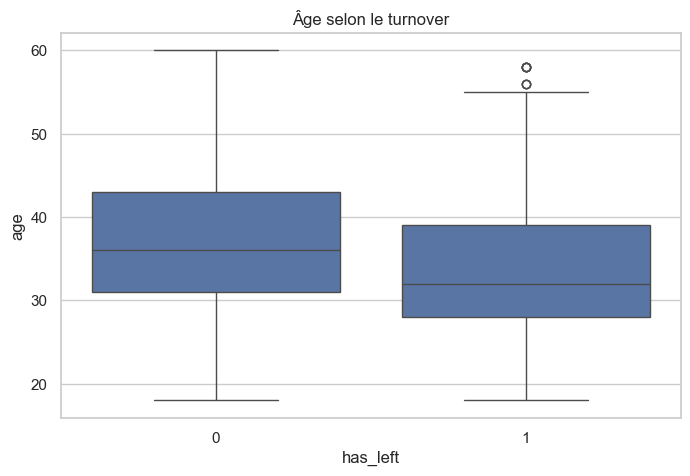

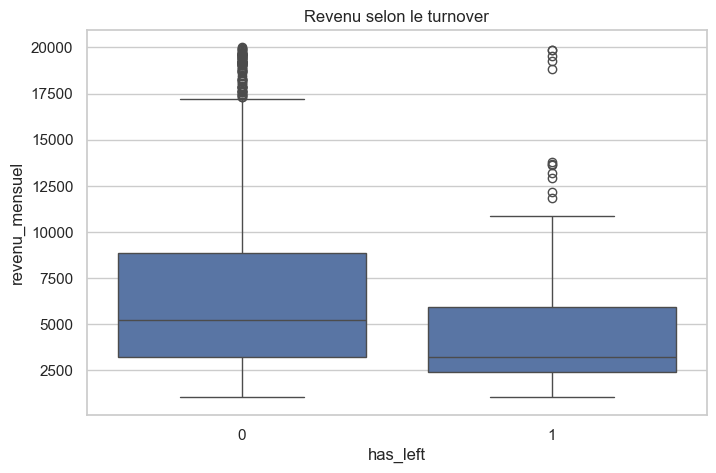

In [88]:
# 11/ Analyse des facteurs liés au turnover

# Objectif : Comparer les variables explicatives selon la cible.
# Pourquoi ? Identifier les facteurs influençant le départ des employés.
# Résultat : Certaines variables (satisfaction, ancienneté, distance, etc.) semblent influencer le turnover.

sns.boxplot(data=df, x="has_left", y="age")
plt.title("Âge selon le turnover")
plt.show()

sns.boxplot(data=df, x="has_left", y="revenu_mensuel")
plt.title("Revenu selon le turnover")
plt.show()

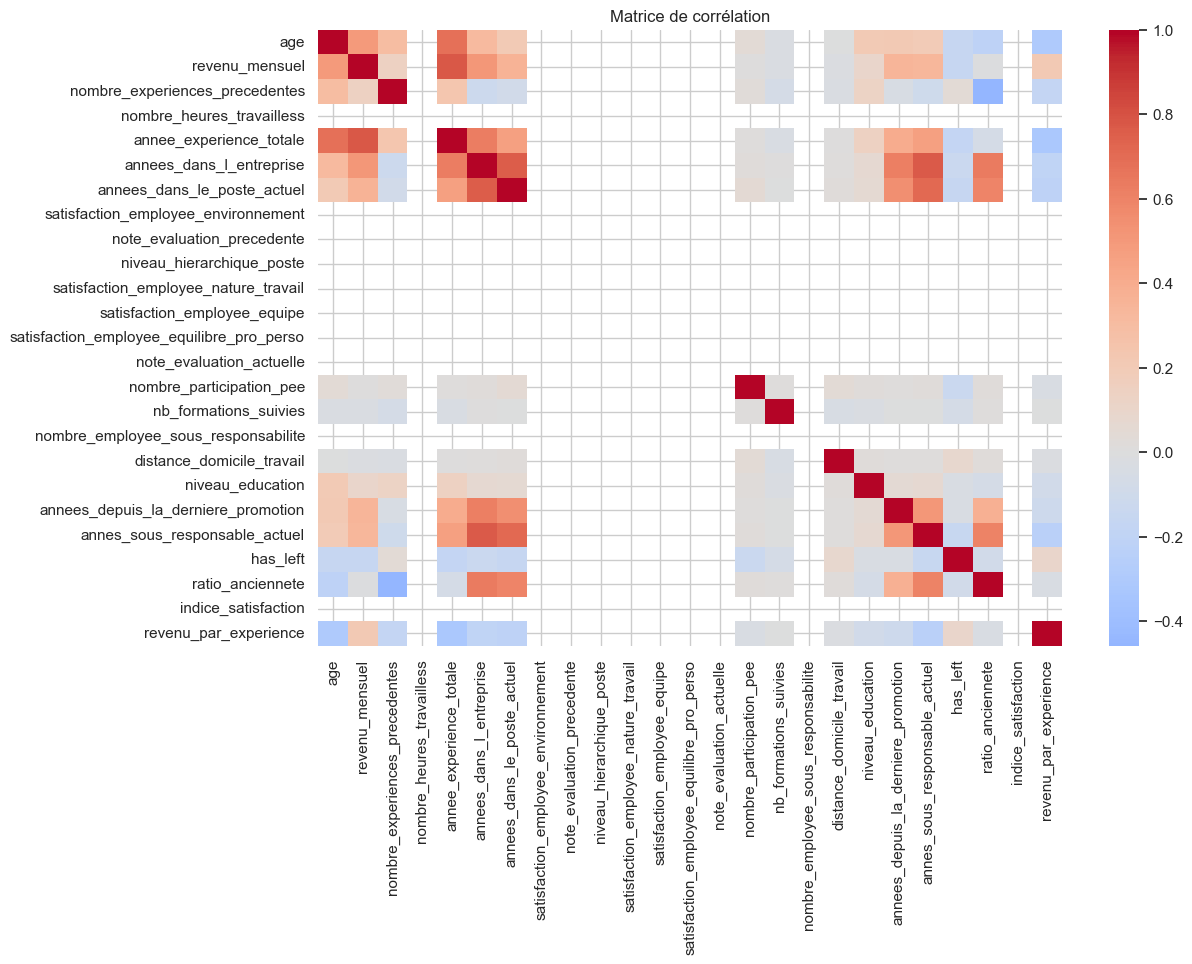

In [89]:
# 12/ Matrice de corrélation

# Objectif :Visualiser les corrélations via une heatmap.
# Pourquoi ? Obtenir une vue globale des relations entre variables numériques.
# Résultat : La heatmap confirme les relations identifiées précédemment.

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation")
plt.show()

In [90]:
# 13/ Détection de features quantitatives redondantes

#Objectif : Identifier les variables quantitatives fortement corrélées entre elles.
#Pourquoi ? Une corrélation élevée (supérieure au seuil défini) peut indiquer une redondance d’information, ce qui peut nuire à l’interprétation et à la stabilité du modèle.
#Résultat : Les paires de variables ayant une corrélation supérieure au seuil sont affichées afin d’évaluer si certaines doivent être supprimées.

high_corr[high_corr["correlation"] > threshold]

,feature_1,feature_2,correlation
